In [2]:
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf
from caiman.paths import caiman_datadir

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

2024-02-22 15:20:04.616455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 15:20:04.616516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 15:20:04.617745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading BokehJS ...

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

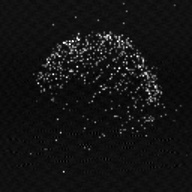

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

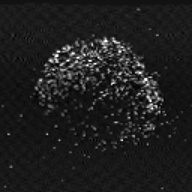

In [5]:
# d = '/jukebox/mcbride/bjarnold/refactor_lukas_imaging_workflow/data/MotionCorrection/BeforeCorrection/240111/240111_Camphor_1U_F1/spontaneous'
# f = '240111_Camphor_1U_F1_00001_00001.tif'
# d = '/jukebox/mcbride/bjarnold/refactor_lukas_imaging_workflow/data/MotionCorrection/CorrectedDataWithin/240111/240111_Camphor_1U_F1/odorEvoked'
# f = '240111_Camphor_1U_F1_00007_00001.tif-mc.tif'


# good images
# 00009
# 00022


x_dim, y_dim = 128, 128

def reshape(Y, z_stacks, x_dim, y_dim):
    # 1st dimension of Y is time X z_stacks, so reshape according to specified z_stacks
    Y_reshaped = np.reshape(Y, (int(Y.shape[0]/z_stacks), z_stacks, x_dim, y_dim))
    # transpose to (n_frames, x, y, z)
    Y_reshaped2 = np.transpose(Y_reshaped, (0, 2, 3, 1))
    return Y_reshaped2

img_num = '00009'

# my results
# base_dir = '/jukebox/mcbride/bjarnold/refactor_lukas_imaging_workflow/data/MotionCorrection'
# Lukas's results
base_dir = '/jukebox/mcbride/lukas/CalciumImaging/FCV/Analysis/MotionCorrection'

d_before = f'{base_dir}/BeforeCorrection/240111/240111_Camphor_1U_F1/odorEvoked'
f_before = f'240111_Camphor_1U_F1_{img_num}_00001.tif'

d_correctedbet = f'{base_dir}/CorrectedDataBetween/240111/240111_Camphor_1U_F1'
f_correctedbet = f'240111_Camphor_1U_F1_{img_num}_00001.tif-mc.tif.between.tif'

# Y = cm.load(f'{d}/{f}')
# print(Y.shape)

Y_before = reshape( cm.load(f'{d_before}/{f_before}'), 
                   22, x_dim, y_dim)
Y_correctedbetween = reshape(cm.load(f'{d_correctedbet}/{f_correctedbet}'), 
                             24, x_dim, y_dim)


# play movie 2X
cm.concatenate([Y_before[...,13]]*4, ).play(magnification=1.5, backend='embed_opencv', fr=150) 
cm.concatenate([Y_correctedbetween[...,13]]*4,  ).play(magnification=1.5, backend='embed_opencv', fr=150)

# Y_before[...,13].play(magnification=1.5, backend='embed_opencv') 
# Y_correctedbetween[...,13].play(magnification=1.5, backend='embed_opencv') 



In [ ]:

Cn = cm.local_correlations(Y_reshaped2, swap_dim=False)
d1, d2, d3 = Y_reshaped2.shape[1], Y_reshaped2.shape[2], Y_reshaped2.shape[3]
x, y = (int(1.2 * (d1 + d3)), int(1.2 * (d2 + d3)))
scale = 6/x
fig = plt.figure(figsize=(scale*x, scale*y))
axz = fig.add_axes([1-d1/x, 1-d2/y, d1/x, d2/y])
plt.imshow(Cn.max(2), cmap='gray')
plt.title('Max.proj. z')
plt.xlabel('x')
plt.ylabel('y')
axy = fig.add_axes([0, 1-d2/y, d3/x, d2/y])
plt.imshow(Cn.max(0), cmap='gray')
plt.title('Max.proj. x')
plt.xlabel('z')
plt.ylabel('y')
axx = fig.add_axes([1-d1/x, 0, d1/x, d3/y])
plt.imshow(Cn.max(1).T, cmap='gray')
plt.title('Max.proj. y')
plt.xlabel('x')
plt.ylabel('z');
plt.show()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

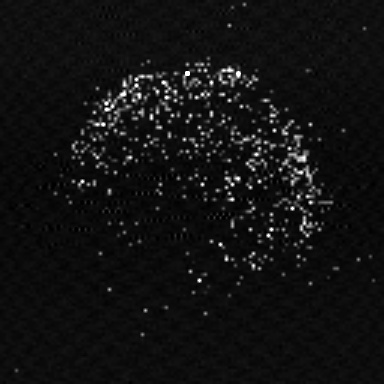

In [ ]:
Y_reshaped2[...,13].play(magnification=3, backend='embed_opencv') 


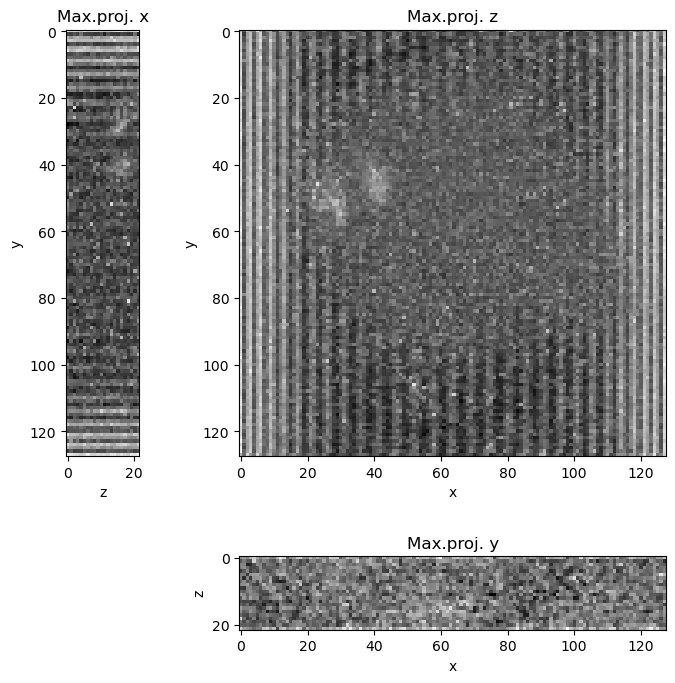

In [ ]:
Cn = cm.local_correlations(Y_reshaped2, swap_dim=False)
d1, d2, d3 = Y_reshaped2.shape[1], Y_reshaped2.shape[2], Y_reshaped2.shape[3]
x, y = (int(1.2 * (d1 + d3)), int(1.2 * (d2 + d3)))
scale = 6/x
fig = plt.figure(figsize=(scale*x, scale*y))
axz = fig.add_axes([1-d1/x, 1-d2/y, d1/x, d2/y])
plt.imshow(Cn.max(2), cmap='gray')
plt.title('Max.proj. z')
plt.xlabel('x')
plt.ylabel('y')
axy = fig.add_axes([0, 1-d2/y, d3/x, d2/y])
plt.imshow(Cn.max(0), cmap='gray')
plt.title('Max.proj. x')
plt.xlabel('z')
plt.ylabel('y')
axx = fig.add_axes([1-d1/x, 0, d1/x, d3/y])
plt.imshow(Cn.max(1).T, cmap='gray')
plt.title('Max.proj. y')
plt.xlabel('x')
plt.ylabel('z');
plt.show()

In [ ]:
dir(Cn)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__o

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__o

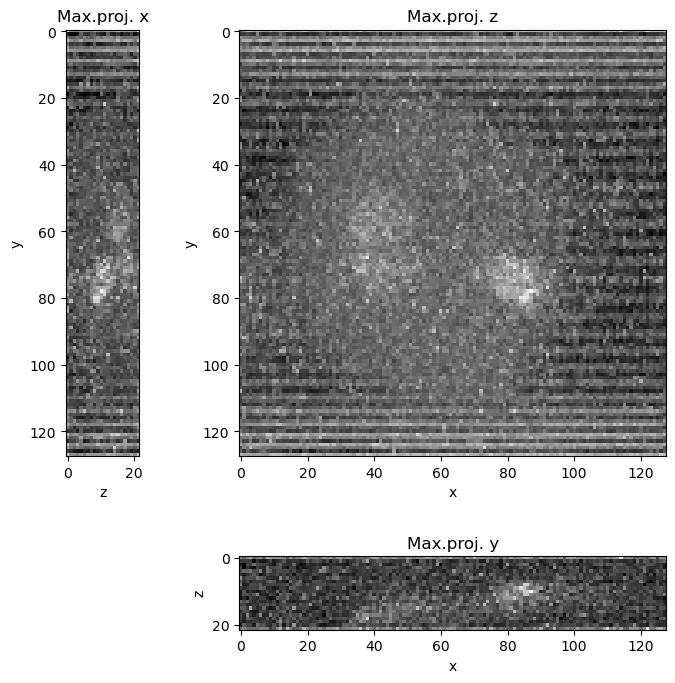

In [ ]:
Cn = cm.local_correlations(Y_reshaped2, swap_dim=False)
d1, d2, d3 = Y_reshaped2.shape[1], Y_reshaped2.shape[2], Y_reshaped2.shape[3]
x, y = (int(1.2 * (d1 + d3)), int(1.2 * (d2 + d3)))
scale = 6/x
fig = plt.figure(figsize=(scale*x, scale*y))
axz = fig.add_axes([1-d1/x, 1-d2/y, d1/x, d2/y])
plt.imshow(Cn.max(2).T, cmap='gray')
plt.title('Max.proj. z')
plt.xlabel('x')
plt.ylabel('y')
axy = fig.add_axes([0, 1-d2/y, d3/x, d2/y])
plt.imshow(Cn.max(0), cmap='gray')
plt.title('Max.proj. x')
plt.xlabel('z')
plt.ylabel('y')
axx = fig.add_axes([1-d1/x, 0, d1/x, d3/y])
plt.imshow(Cn.max(1).T, cmap='gray')
plt.title('Max.proj. y')
plt.xlabel('x')
plt.ylabel('z');
plt.show()

In [ ]:


# Z*T = 2486, which is 22*113
Y_reshaped = np.reshape(Y, (113, 22, 128, 128))
Y_reshaped2 = np.transpose(Y_reshaped, (0, 2, 3, 1))

# Y_reshaped = np.reshape(Y, (22, 113, 128, 128))
# Y_reshaped2 = np.transpose(Y_reshaped, (1, 2, 3, 0))

# Y_reshaped = np.transpose(Y, (1, 2, 0))
# Y_reshaped2 = np.reshape(Y, (128, 128, 22, 113))
print(Y_reshaped.shape)
print(Y_reshaped2.shape)

(113, 22, 128, 128)
(113, 128, 128, 22)


In [ ]:
def gen_data(p=1, noise=.5, T=256, framerate=30, firerate=2., motion=True, plot=False):
    if p == 2:
        gamma = np.array([1.5, -.55])
    elif p == 1:
        gamma = np.array([.9])
    else:
        raise
    dims = (70, 50, 10)  # size of image
    sig = (4, 4, 2)  # neurons size
    bkgrd = 10
    N = 20  # number of neurons
    np.random.seed(0)
    centers = np.asarray([[np.random.randint(s, x - s)
                           for x, s in zip(dims, sig)] for i in range(N)])
    if motion:
        centers += np.array(sig) * 2
        Y = np.zeros((T,) + tuple(np.array(dims) + np.array(sig) * 4), dtype=np.float32)      
    else:
        Y = np.zeros((T,) + dims, dtype=np.float32)
    trueSpikes = np.random.rand(N, T) < firerate / float(framerate)
    trueSpikes[:, 0] = 0
    truth = trueSpikes.astype(np.float32)
    for i in range(2, T):
        if p == 2:
            truth[:, i] += gamma[0] * truth[:, i - 1] + gamma[1] * truth[:, i - 2]
        else:
            truth[:, i] += gamma[0] * truth[:, i - 1]
    for i in range(N):
        Y[:, centers[i, 0], centers[i, 1], centers[i, 2]] = truth[i]
    tmp = np.zeros(dims)
    tmp[tuple(np.array(dims)//2)] = 1.
    z = np.linalg.norm(gaussian_filter(tmp, sig).ravel())
    Y = bkgrd + noise * np.random.randn(*Y.shape) + 10 * gaussian_filter(Y, (0,) + sig) / z
    if motion:
        shifts = np.transpose([np.convolve(np.random.randn(T-10), np.ones(11)/11*s) for s in sig])
        Y = np.array([cm.motion_correction.apply_shifts_dft(img, (sh[0], sh[1], sh[2]), 0,
                                                                     is_freq=False, border_nan='copy')
                               for img, sh in zip(Y, shifts)])
        Y = Y[:, 2*sig[0]:-2*sig[0], 2*sig[1]:-2*sig[1], 2*sig[2]:-2*sig[2]]
    else:
        shifts = None
    T, d1, d2, d3 = Y.shape

    if plot:
        Cn = cm.local_correlations(Y, swap_dim=False)
        plt.figure(figsize=(15, 3))
        plt.plot(truth.T)
        plt.figure(figsize=(15, 3))
        for c in centers:
            plt.plot(Y[c[0], c[1], c[2]])

        d1, d2, d3 = dims
        x, y = (int(1.2 * (d1 + d3)), int(1.2 * (d2 + d3)))
        scale = 6/x
        fig = plt.figure(figsize=(scale*x, scale*y))
        axz = fig.add_axes([1-d1/x, 1-d2/y, d1/x, d2/y])
        plt.imshow(Cn.max(2).T, cmap='gray')
        plt.scatter(*centers.T[:2], c='r')
        plt.title('Max.proj. z')
        plt.xlabel('x')
        plt.ylabel('y')
        axy = fig.add_axes([0, 1-d2/y, d3/x, d2/y])
        plt.imshow(Cn.max(0), cmap='gray')
        plt.scatter(*centers.T[:0:-1], c='r')
        plt.title('Max.proj. x')
        plt.xlabel('z')
        plt.ylabel('y')
        axx = fig.add_axes([1-d1/x, 0, d1/x, d3/y])
        plt.imshow(Cn.max(1).T, cmap='gray')
        plt.scatter(*centers.T[np.array([0,2])], c='r')
        plt.title('Max.proj. y')
        plt.xlabel('x')
        plt.ylabel('z');
        plt.show()

    return Y, truth, trueSpikes, centers, dims, -shifts

In [ ]:
fname = os.path.join(caiman_datadir(), 'example_movies', 'demoMovie3D.tif')
Y, truth, trueSpikes, centers, dims, shifts = gen_data(p=2)
imwrite(fname, Y)
print(fname)

/usr/people/bjarnold/caiman_data/example_movies/demoMovie3D.tif


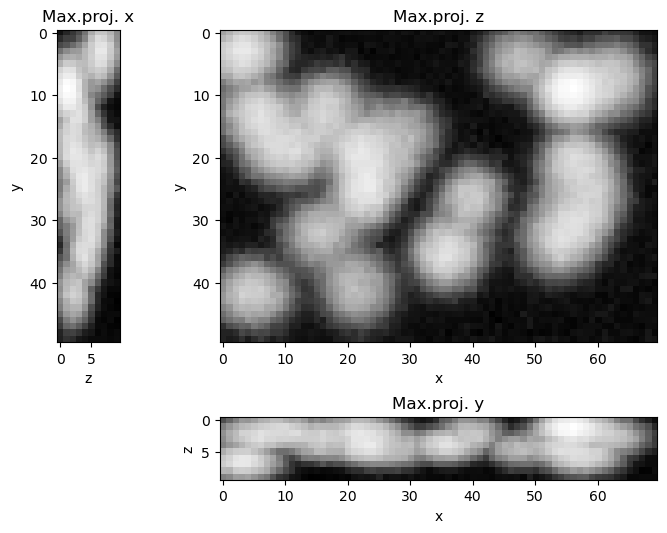

In [ ]:
Y = cm.load(fname)
Cn = cm.local_correlations(Y, swap_dim=False)
d1, d2, d3 = dims
x, y = (int(1.2 * (d1 + d3)), int(1.2 * (d2 + d3)))
scale = 6/x
fig = plt.figure(figsize=(scale*x, scale*y))
axz = fig.add_axes([1-d1/x, 1-d2/y, d1/x, d2/y])
plt.imshow(Cn.max(2).T, cmap='gray')
plt.title('Max.proj. z')
plt.xlabel('x')
plt.ylabel('y')
axy = fig.add_axes([0, 1-d2/y, d3/x, d2/y])
plt.imshow(Cn.max(0), cmap='gray')
plt.title('Max.proj. x')
plt.xlabel('z')
plt.ylabel('y')
axx = fig.add_axes([1-d1/x, 0, d1/x, d3/y])
plt.imshow(Cn.max(1).T, cmap='gray')
plt.title('Max.proj. y')
plt.xlabel('x')
plt.ylabel('z');
plt.show()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

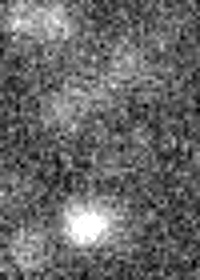

In [ ]:
Y[...,5].play(magnification=4, backend='embed_opencv')


In [ ]:
# 246 frames, 3D image size 70x50x10
print(Y.shape)
print(dims)

(256, 70, 50, 10)
(70, 50, 10)


(256, 70, 50, 10)
(70, 50, 10)


(256, 70, 50, 10)
(70, 50, 10)


In [ ]:
print(Cn.shape)

(70, 50, 10)


(70, 50, 10)


In [ ]:
Y[...,0:3].shape

(256, 70, 50, 3)

(256, 70, 50, 3)

In [ ]:
Y

movie([[[[ 9.938191 , 10.694378 ,  9.510903 , ...,  9.555268 ,
           9.969276 , 10.982164 ],
         [ 9.0858345, 10.286882 , 10.386082 , ...,  9.233175 ,
           9.85765  , 10.051952 ],
         [ 9.691803 ,  9.59273  , 10.630237 , ...,  9.798525 ,
          10.722654 ,  9.670035 ],
         ...,
         [10.235848 , 10.305686 , 10.086492 , ..., 10.589463 ,
          10.294912 ,  9.187128 ],
         [10.324617 , 10.21725  , 10.089347 , ...,  9.363062 ,
           9.510042 , 10.477956 ],
         [10.020663 , 10.581751 , 10.260335 , ...,  9.192643 ,
           9.956977 ,  9.623926 ]],

        [[ 9.453733 ,  9.937405 , 10.468122 , ..., 10.140294 ,
           9.217828 , 10.53954  ],
         [10.555208 , 10.993772 ,  9.6782   , ...,  9.747274 ,
          10.000634 , 10.104708 ],
         [10.53048  ,  9.1822815, 10.791614 , ...,  8.7633915,
           9.524834 ,  9.724009 ],
         ...,
         [ 9.727669 ,  9.047555 , 10.521874 , ..., 11.183775 ,
          10.294331 , 10.

movie([[[[ 9.938191 , 10.694378 ,  9.510903 , ...,  9.555268 ,
           9.969276 , 10.982164 ],
         [ 9.0858345, 10.286882 , 10.386082 , ...,  9.233175 ,
           9.85765  , 10.051952 ],
         [ 9.691803 ,  9.59273  , 10.630237 , ...,  9.798525 ,
          10.722654 ,  9.670035 ],
         ...,
         [10.235848 , 10.305686 , 10.086492 , ..., 10.589463 ,
          10.294912 ,  9.187128 ],
         [10.324617 , 10.21725  , 10.089347 , ...,  9.363062 ,
           9.510042 , 10.477956 ],
         [10.020663 , 10.581751 , 10.260335 , ...,  9.192643 ,
           9.956977 ,  9.623926 ]],

        [[ 9.453733 ,  9.937405 , 10.468122 , ..., 10.140294 ,
           9.217828 , 10.53954  ],
         [10.555208 , 10.993772 ,  9.6782   , ...,  9.747274 ,
          10.000634 , 10.104708 ],
         [10.53048  ,  9.1822815, 10.791614 , ...,  8.7633915,
           9.524834 ,  9.724009 ],
         ...,
         [ 9.727669 ,  9.047555 , 10.521874 , ..., 11.183775 ,
          10.294331 , 10.

In [ ]:
d = '/jukebox/mcbride/bjarnold/refactor_lukas_imaging_workflow/data/MotionCorrection/BeforeCorrection/240111/240111_Camphor_1U_F1/spontaneous'
f = '240111_Camphor_1U_F1_00001_00001.tif'
Y = cm.load(f'{d}/{f}')
print(Y.shape)

# Z*T = 2486, which is 22*113
Y_reshaped = np.reshape(Y, (113, 22, 128, 128))
Y_reshaped2 = np.transpose(Y_reshaped, (0, 2, 3, 1))

# Y_reshaped = np.reshape(Y, (22, 113, 128, 128))
# Y_reshaped2 = np.transpose(Y_reshaped, (1, 2, 3, 0))

# Y_reshaped = np.transpose(Y, (1, 2, 0))
# Y_reshaped2 = np.reshape(Y, (128, 128, 22, 113))
print(Y_reshaped.shape)
print(Y_reshaped2.shape)

(2486, 128, 128)
(113, 22, 128, 128)
(113, 128, 128, 22)


(2486, 128, 128)
(113, 22, 128, 128)
(113, 128, 128, 22)


ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

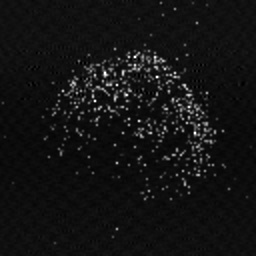

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

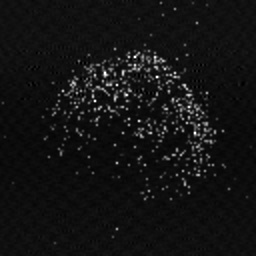

In [ ]:
Y_reshaped2[...,11].play(magnification=2, backend='embed_opencv') 


In [ ]:
Cn = cm.local_correlations(Y, swap_dim=False)
d1, d2, d3 = dims
x, y = (int(1.2 * (d1 + d3)), int(1.2 * (d2 + d3)))
scale = 6/x
fig = plt.figure(figsize=(scale*x, scale*y))
axz = fig.add_axes([1-d1/x, 1-d2/y, d1/x, d2/y])
plt.imshow(Cn.max(2).T, cmap='gray')
plt.title('Max.proj. z')
plt.xlabel('x')
plt.ylabel('y')
axy = fig.add_axes([0, 1-d2/y, d3/x, d2/y])
plt.imshow(Cn.max(0), cmap='gray')
plt.title('Max.proj. x')
plt.xlabel('z')
plt.ylabel('y')
axx = fig.add_axes([1-d1/x, 0, d1/x, d3/y])
plt.imshow(Cn.max(1).T, cmap='gray')
plt.title('Max.proj. y')
plt.xlabel('x')
plt.ylabel('z');
plt.show()

NameError: name 'dims' is not defined

<Figure size 600x450 with 0 Axes>

<Figure size 600x450 with 0 Axes>

AxisError: axis 2 is out of bounds for array of dimension 2